In [54]:
import pandas as pd
import numpy as np
from pathlib import Path

pd.set_option("display.max_columns", 80)

BASE = Path.cwd().parent
RAW = BASE / "data" / "raw" / "brazilian-ecommerce"
PROC = BASE / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

print("RAW:", RAW.resolve())
print("PROC:", PROC.resolve())


RAW: /Users/sebastianklotzing/dpp/data/raw/brazilian-ecommerce
PROC: /Users/sebastianklotzing/dpp/data/processed


In [55]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

orders      = pd.read_csv(RAW / "olist_orders_dataset.csv", parse_dates=date_cols)
order_items = pd.read_csv(RAW / "olist_order_items_dataset.csv")
products    = pd.read_csv(RAW / "olist_products_dataset.csv")
customers   = pd.read_csv(RAW / "olist_customers_dataset.csv")
sellers     = pd.read_csv(RAW / "olist_sellers_dataset.csv")
payments    = pd.read_csv(RAW / "olist_order_payments_dataset.csv")
reviews     = pd.read_csv(RAW / "olist_order_reviews_dataset.csv")
geolocation = pd.read_csv(RAW / "olist_geolocation_dataset.csv")
cat_trans   = pd.read_csv(RAW / "product_category_name_translation.csv")

print({ 
    "orders": orders.shape, "order_items": order_items.shape, "products": products.shape,
    "customers": customers.shape, "sellers": sellers.shape, "payments": payments.shape,
    "reviews": reviews.shape, "geolocation": geolocation.shape, "cat_trans": cat_trans.shape
})


{'orders': (99441, 8), 'order_items': (112650, 7), 'products': (32951, 9), 'customers': (99441, 5), 'sellers': (3095, 4), 'payments': (103886, 5), 'reviews': (99224, 7), 'geolocation': (1000163, 5), 'cat_trans': (71, 2)}


In [56]:
# Kategorienamen auf Englisch anhängen
products = products.merge(
    cat_trans.rename(columns={
        "product_category_name": "product_category_name",
        "product_category_name_english": "product_category_name_english"
    }),
    on="product_category_name",
    how="left"
)

# ein paar praktische Zeitfelder
orders["order_date"]  = orders["order_purchase_timestamp"].dt.date
orders["order_month"] = orders["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()
orders["order_year"]  = orders["order_purchase_timestamp"].dt.year
orders["order_wday"]  = orders["order_purchase_timestamp"].dt.day_name(locale="en_US")


In [57]:
# nur sinnvolle Bestellstatus
valid_status = ~orders["order_status"].isin(["canceled", "unavailable"])

fact = (
    order_items
    .merge(
        orders.loc[valid_status, [
            "order_id", "customer_id", "order_status",
            "order_purchase_timestamp", "order_date", "order_month", "order_year", "order_wday"
        ]],
        on="order_id", how="inner"
    )
    .merge(
        products[["product_id", "product_category_name", "product_category_name_english"]],
        on="product_id", how="left"
    )
    .merge(
        customers[["customer_id", "customer_state", "customer_city"]],
        on="customer_id", how="left"
    )
    .merge(
        sellers[["seller_id", "seller_state", "seller_city"]],
        on="seller_id", how="left"
    )
)

# Metriken
fact["item_revenue_brl"] = fact["price"].astype(float)
fact["freight_brl"]      = fact["freight_value"].astype(float)
fact["items_count"]      = 1  # eine Zeile je Position

# schlanke Auswahl
fact = fact[[
    "order_id", "order_item_id",
    "order_purchase_timestamp", "order_date", "order_month", "order_year", "order_wday",
    "customer_id", "customer_city", "customer_state",
    "seller_id", "seller_city", "seller_state",
    "product_id", "product_category_name", "product_category_name_english",
    "item_revenue_brl", "freight_brl", "items_count"
]].copy()

fact.head()


,order_id,order_item_id,order_purchase_timestamp,order_date,order_month,order_year,order_wday,customer_id,customer_city,customer_state,seller_id,seller_city,seller_state,product_id,product_category_name,product_category_name_english,item_revenue_brl,freight_brl,items_count
0,00010242fe8c5a6d1ba2dd792cb16214,1,2017-09-13 08:59:02,2017-09-13,2017-09-01,2017,Wednesday,3ce436f183e68e07877b285a838db11a,campos dos goytacazes,RJ,48436dade18ac8b2bce089ec2a041202,volta redonda,SP,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,cool_stuff,58.90,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,1,2017-04-26 10:53:06,2017-04-26,2017-04-01,2017,Wednesday,f6dd3ec061db4e3987629fe6b26e5cce,santa fe do sul,SP,dd7ddc04e1b6c2c614352b383efe2d36,sao paulo,SP,e5f2d52b802189ee658865ca93d83a8f,pet_shop,pet_shop,239.90,19.93,1
2,000229ec398224ef6ca0657da4fc703e,1,2018-01-14 14:33:31,2018-01-14,2018-01-01,2018,Sunday,6489ae5e4333f3693df5ad4372dab6d3,para de minas,MG,5b51032eddd242adc84c38acab88f23d,borda da mata,MG,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,furniture_decor,199.00,17.87,1
3,00024acbcdf0a6daa1e931b038114c75,1,2018-08-08 10:00:35,2018-08-08,2018-08-01,2018,Wednesday,d4eb9395c8c0431ee92fce09860c5a06,atibaia,SP,9d7a1d34a5052409006425275ba1c2b4,franca,SP,7634da152a4610f1595efa32f14722fc,perfumaria,perfumery,12.99,12.79,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,2017-02-04 13:57:51,2017-02-04,2017-02-01,2017,Saturday,58dbd0b2d70206bf40e62cd34e84d795,varzea paulista,SP,df560393f3a51e74553ab94004ba5c87,loanda,PR,ac6c3623068f30de03045865e4e10089,ferramentas_jardim,garden_tools,199.90,18.14,1


In [58]:
print("Zeilen Faktentabelle:", len(fact))
gmv_total = fact["item_revenue_brl"].sum()
print("GMV gesamt BRL:", round(gmv_total, 2))

# einfache Checks
assert fact["item_revenue_brl"].ge(0).all()
assert fact["items_count"].sum() == len(fact)


Zeilen Faktentabelle: 112101
GMV gesamt BRL: 13494400.74


In [59]:
fact.to_parquet(PROC / "fact_order_items.parquet", index=False)
fact.to_csv(PROC / "fact_order_items_sample.csv", index=False)
print("Geschrieben:", (PROC / "fact_order_items.parquet").name)


Geschrieben: fact_order_items.parquet


In [60]:
gmv_by_month = fact.groupby("order_month")["item_revenue_brl"].sum().rename("gmv_brl")
gmv_by_cat   = fact.groupby("product_category_name_english")["item_revenue_brl"].sum().sort_values(ascending=False)
gmv_by_seller= fact.groupby("seller_id")["item_revenue_brl"].sum().sort_values(ascending=False)
gmv_by_state = fact.groupby("customer_state")["item_revenue_brl"].sum().sort_values(ascending=False)

gmv_by_month.to_csv(PROC / "gmv_by_month.csv")
gmv_by_cat.to_csv(PROC / "gmv_by_category.csv")
gmv_by_seller.to_csv(PROC / "gmv_by_seller.csv")
gmv_by_state.to_csv(PROC / "gmv_by_state.csv")

print("Aggregationen gespeichert")


Aggregationen gespeichert


Verwendete Spalten: ['price', 'freight_value', 'item_revenue_brl', 'delivery_days', 'review_score']


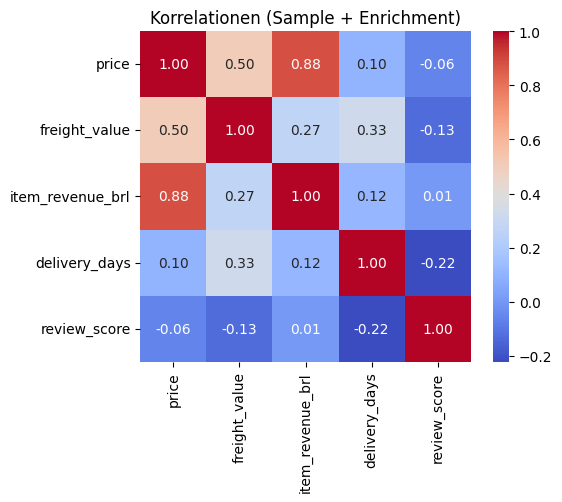

In [61]:
import pandas as pd
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt

# ---- Pfade
BASE = Path.cwd().parent        # wenn Notebook in /notebooks liegt
PROC = BASE / "data" / "processed"
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

df = pd.read_csv(PROC / "fact_order_items_sample.csv", parse_dates=["order_purchase_timestamp"], low_memory=False)

# ---- 1) Preis & Fracht je Order aus order_items (falls in Sample nicht vorhanden)
if not {"price","freight_value"}.issubset(df.columns):
    oi = pd.read_csv(RAW / "olist_order_items_dataset.csv", usecols=["order_id","price","freight_value"])
    oi_sum = oi.groupby("order_id", as_index=False)[["price","freight_value"]].sum()
    df = df.merge(oi_sum, on="order_id", how="left")

# ---- 2) Lieferzeit (delivery_days) aus orders
if "delivery_days" not in df.columns:
    orders = pd.read_csv(
        RAW / "olist_orders_dataset.csv",
        usecols=["order_id","order_status","order_purchase_timestamp","order_delivered_customer_date"],
        parse_dates=["order_purchase_timestamp","order_delivered_customer_date"]
    )
    orders = orders[orders["order_status"]=="delivered"].copy()
    orders["delivery_days"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days
    df = df.merge(orders[["order_id","delivery_days"]], on="order_id", how="left")

# ---- 3) Review-Score je Order
if "review_score" not in df.columns:
    rev = pd.read_csv(RAW / "olist_order_reviews_dataset.csv", usecols=["order_id","review_score"])
    rev = rev.groupby("order_id", as_index=False)["review_score"].mean()
    df = df.merge(rev, on="order_id", how="left")

# ---- 4) Fallback: item_revenue_brl, falls nicht vorhanden
if "item_revenue_brl" not in df.columns and {"price","freight_value"}.issubset(df.columns):
    df["item_revenue_brl"] = df["price"].fillna(0) + df["freight_value"].fillna(0)

# ---- 5) Korrelation rechnen (robust & nur valide Spalten)
candidates = ["price","freight_value","item_revenue_brl","delivery_days","review_score"]
num_cols = [c for c in candidates if c in df.columns]
num = df[num_cols].apply(pd.to_numeric, errors="coerce")

# leere/konstante Spalten entfernen
num = num.loc[:, num.notna().any()]                   # nicht komplett NaN
num = num.loc[:, num.nunique(dropna=True) > 1]        # nicht konstant

print("Verwendete Spalten:", num.columns.tolist())
if num.shape[1] < 2:
    raise ValueError("Noch zu wenige numerische Spalten. Prüfe, ob RAW-Dateien korrekt gemerged wurden.")

corr = num.corr(method="spearman")

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Korrelationen (Sample + Enrichment)")
plt.tight_layout()
plt.show()


Verwendete Spalten: ['price', 'freight_value', 'item_revenue_brl', 'delivery_days', 'review_score']


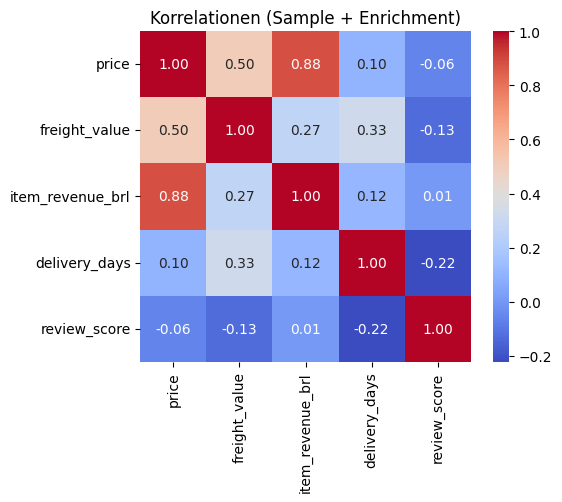

In [62]:
import pandas as pd
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt

# ---- Pfade
BASE = Path.cwd().parent        # wenn Notebook in /notebooks liegt
PROC = BASE / "data" / "processed"
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

df = pd.read_csv(PROC / "fact_order_items_sample.csv", parse_dates=["order_purchase_timestamp"], low_memory=False)

# ---- 1) Preis & Fracht je Order aus order_items (falls in Sample nicht vorhanden)
if not {"price","freight_value"}.issubset(df.columns):
    oi = pd.read_csv(RAW / "olist_order_items_dataset.csv", usecols=["order_id","price","freight_value"])
    oi_sum = oi.groupby("order_id", as_index=False)[["price","freight_value"]].sum()
    df = df.merge(oi_sum, on="order_id", how="left")

# ---- 2) Lieferzeit (delivery_days) aus orders
if "delivery_days" not in df.columns:
    orders = pd.read_csv(
        RAW / "olist_orders_dataset.csv",
        usecols=["order_id","order_status","order_purchase_timestamp","order_delivered_customer_date"],
        parse_dates=["order_purchase_timestamp","order_delivered_customer_date"]
    )
    orders = orders[orders["order_status"]=="delivered"].copy()
    orders["delivery_days"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days
    df = df.merge(orders[["order_id","delivery_days"]], on="order_id", how="left")

# ---- 3) Review-Score je Order
if "review_score" not in df.columns:
    rev = pd.read_csv(RAW / "olist_order_reviews_dataset.csv", usecols=["order_id","review_score"])
    rev = rev.groupby("order_id", as_index=False)["review_score"].mean()
    df = df.merge(rev, on="order_id", how="left")

# ---- 4) Fallback: item_revenue_brl, falls nicht vorhanden
if "item_revenue_brl" not in df.columns and {"price","freight_value"}.issubset(df.columns):
    df["item_revenue_brl"] = df["price"].fillna(0) + df["freight_value"].fillna(0)

# ---- 5) Korrelation rechnen (robust & nur valide Spalten)
candidates = ["price","freight_value","item_revenue_brl","delivery_days","review_score"]
num_cols = [c for c in candidates if c in df.columns]
num = df[num_cols].apply(pd.to_numeric, errors="coerce")

# leere/konstante Spalten entfernen
num = num.loc[:, num.notna().any()]                   # nicht komplett NaN
num = num.loc[:, num.nunique(dropna=True) > 1]        # nicht konstant

print("Verwendete Spalten:", num.columns.tolist())
if num.shape[1] < 2:
    raise ValueError("Noch zu wenige numerische Spalten. Prüfe, ob RAW-Dateien korrekt gemerged wurden.")

corr = num.corr(method="spearman")

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Korrelationen (Sample + Enrichment)")
plt.tight_layout()
plt.show()
